In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from auxii import plot_spectra, analyze_image, analyze_tiff_metadata
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
image_path3 = "/mnt/d/Maestria/tfm/7144071/16_09_2021/Ground_RGB_Photos/Armillaria_Stage_2/6-66.jpg"  
image_path = "/mnt/d/Maestria/tfm/7144071/16_09_2021/Ground_Multispectral_Photos/Armillaria_Stage_2/6-60/IMG_160101_000628_0000_RED.TIF"
analyze_tiff_metadata(image_path)
analyze_image(image_path)


Análisis de la imagen TIFF: IMG_160101_000628_0000_RED.TIF
Dimensiones: (960, 1280)
Modo: RGB
No se pudieron obtener los metadatos TIFF

Metadatos de la banda:

Profundidad de bits: 8 bits
Valor máximo: 255
Valor mínimo: 21

Todos los metadatos disponibles:

Análisis de la imagen: IMG_160101_000628_0000_RED.TIF
Formato: TIFF
Modo: RGB
Dimensiones: (960, 1280)

Número de canales: 3
Canal 1:
  - Bits por pixel: 8
  - Valor máximo: 255
  - Valor mínimo: 21
Canal 2:
  - Bits por pixel: 8
  - Valor máximo: 255
  - Valor mínimo: 21
Canal 3:
  - Bits por pixel: 8
  - Valor máximo: 255
  - Valor mínimo: 21

Bits totales por pixel: 24
Tipo de datos: uint8


In [7]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.Resize((1280, 960)),
    transforms.ToTensor()
])

formats = ( 'RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG',)
dataset = CherryTreeDataset('/mnt/d/Maestria/tfm/7144071', transform=transform, formats = formats, concatenate = True, healthy_ratio=2)

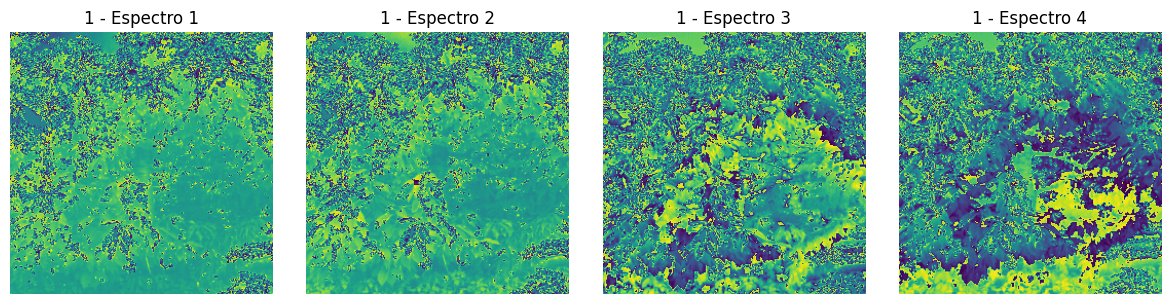

Number of samples for Healthy: 412
Number of samples for Disease: 206


In [9]:
images, label = dataset[20]  
plot_spectra(images, label)
dataset.print_class_counts()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [17]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader para manejar los lotes de datos
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20)

#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
#resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Adapta el modelo para aceptar 4 canales
resnet = adapt_resnet_channels(resnet, 7)

print(resnet)


num_classes = 2  # Número de clases en tu dataset
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(resnet.fc.in_features, 128),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(128, 32),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(32, 1),
)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.layer3.parameters():
    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

print(resnet)
for name, param in resnet.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")



ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

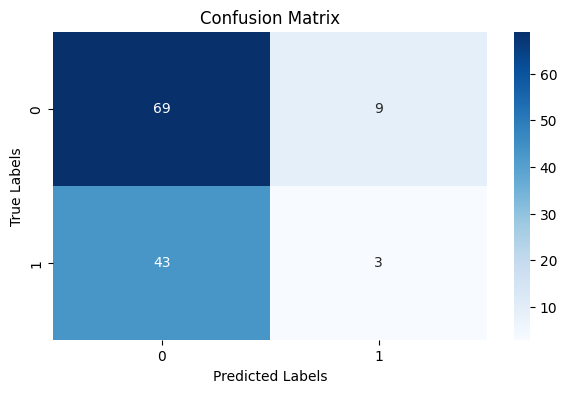

Epoch [1/50], Train Loss: 0.6924, Validation Loss: 0.6859, Accuracy: 58.06%


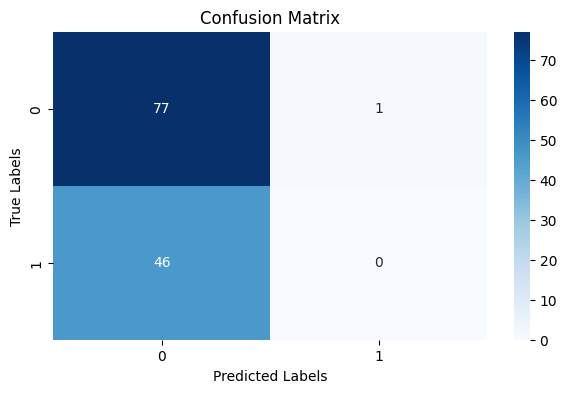

Epoch [2/50], Train Loss: 0.6606, Validation Loss: 0.6665, Accuracy: 62.10%


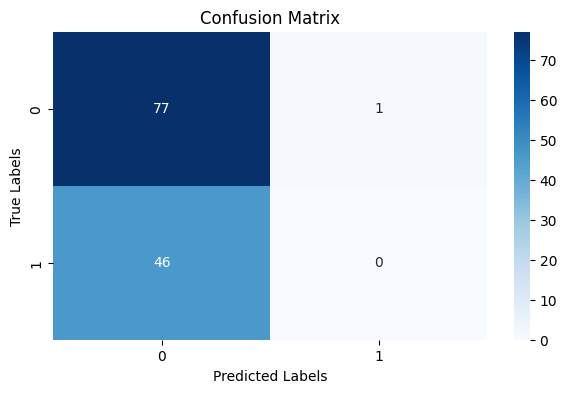

Epoch [3/50], Train Loss: 0.6503, Validation Loss: 0.6518, Accuracy: 62.10%


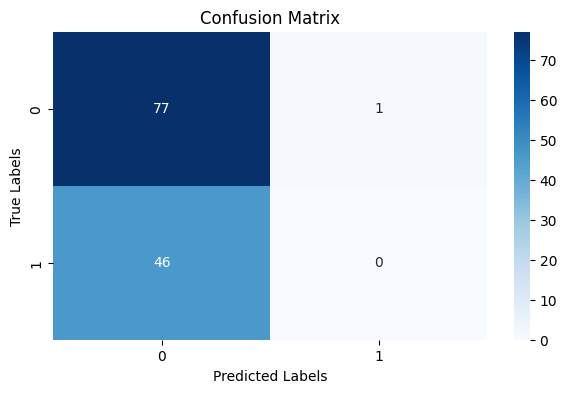

Epoch [4/50], Train Loss: 0.6111, Validation Loss: 0.6312, Accuracy: 62.10%


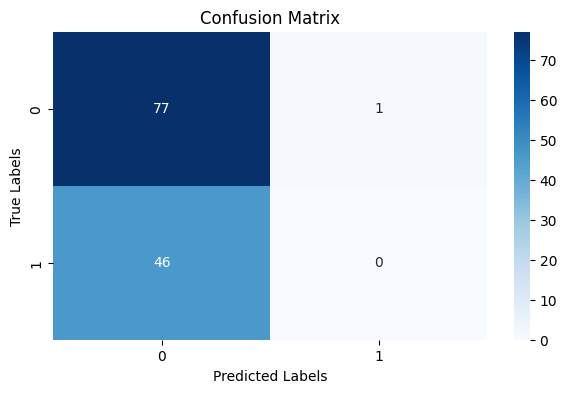

Epoch [5/50], Train Loss: 0.5786, Validation Loss: 0.6202, Accuracy: 62.10%


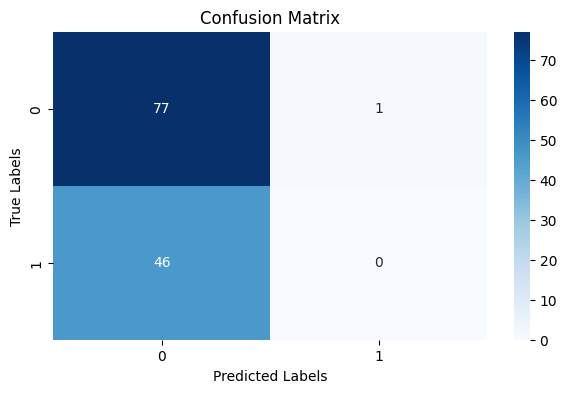

Epoch [6/50], Train Loss: 0.5050, Validation Loss: 0.6079, Accuracy: 62.10%


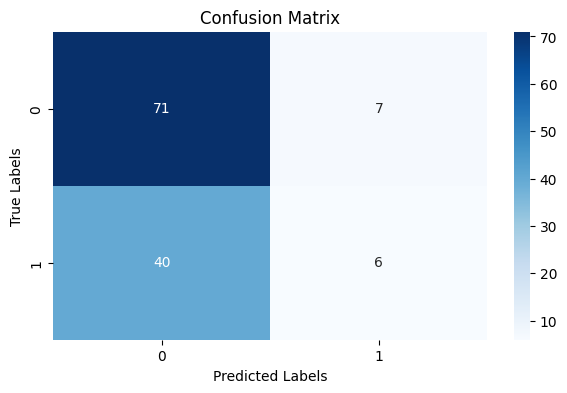

Epoch [7/50], Train Loss: 0.4611, Validation Loss: 0.5908, Accuracy: 62.10%


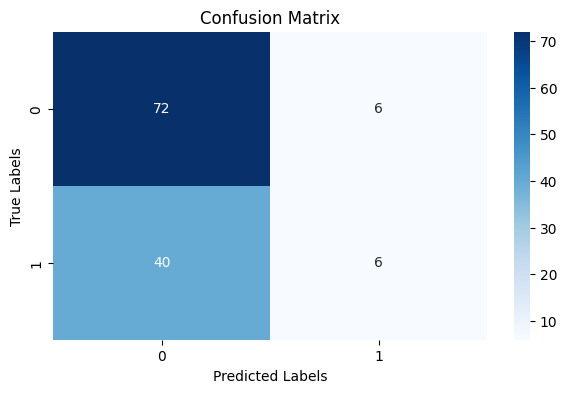

Epoch [8/50], Train Loss: 0.3965, Validation Loss: 0.6093, Accuracy: 62.90%


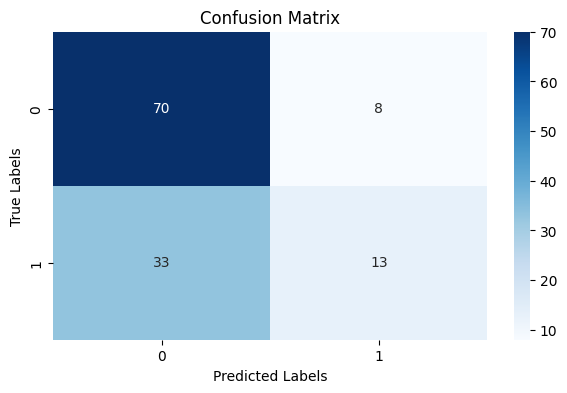

Epoch [9/50], Train Loss: 0.3497, Validation Loss: 0.5906, Accuracy: 66.94%


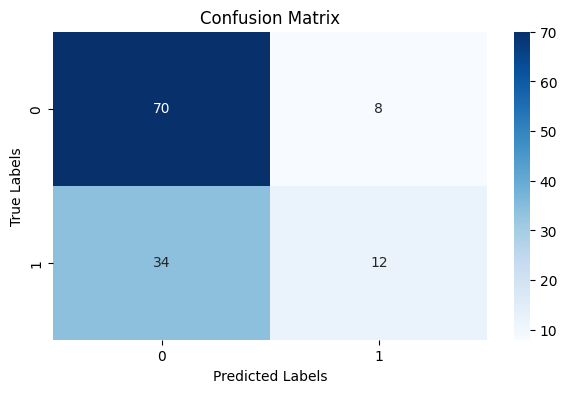

Epoch [10/50], Train Loss: 0.3087, Validation Loss: 0.6092, Accuracy: 66.13%


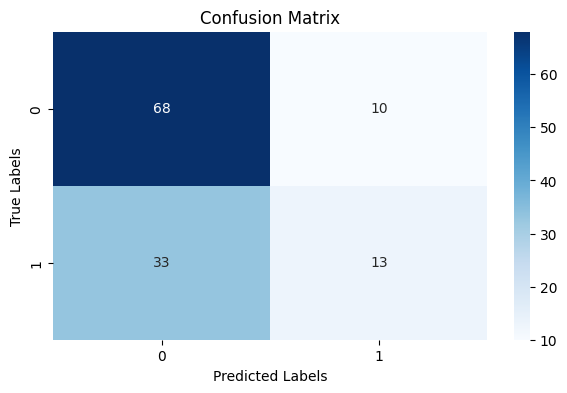

Epoch [11/50], Train Loss: 0.2661, Validation Loss: 0.6363, Accuracy: 65.32%


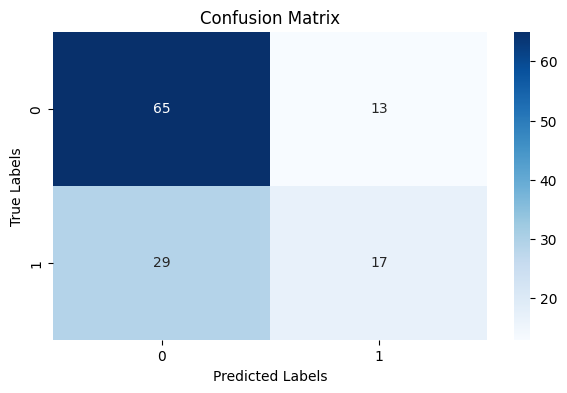

Epoch [12/50], Train Loss: 0.2309, Validation Loss: 0.5949, Accuracy: 66.13%


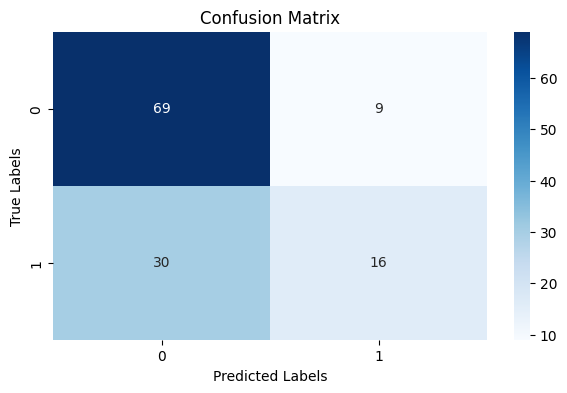

Epoch [13/50], Train Loss: 0.1950, Validation Loss: 0.6441, Accuracy: 68.55%


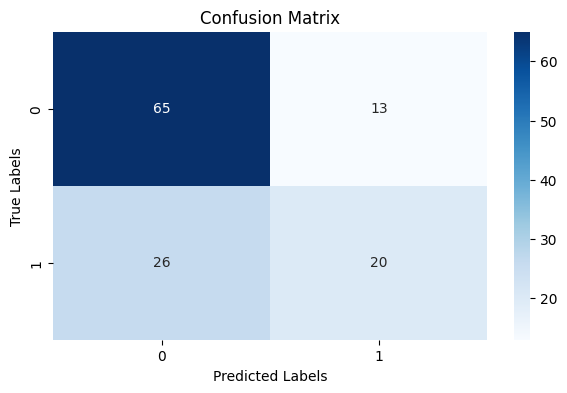

Epoch [14/50], Train Loss: 0.1721, Validation Loss: 0.6322, Accuracy: 68.55%


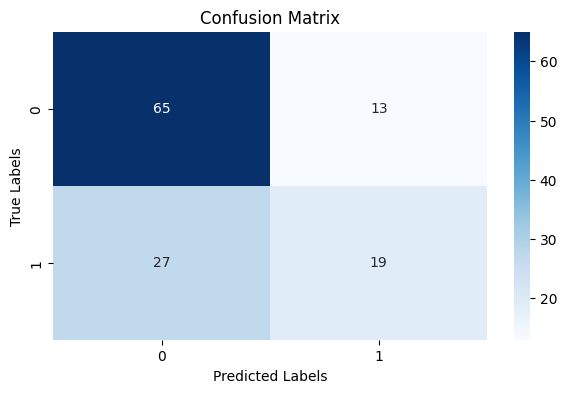

Epoch [15/50], Train Loss: 0.1648, Validation Loss: 0.6626, Accuracy: 67.74%


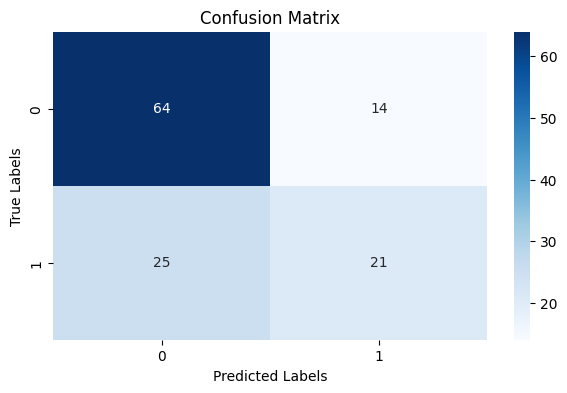

Epoch [16/50], Train Loss: 0.1420, Validation Loss: 0.6418, Accuracy: 68.55%


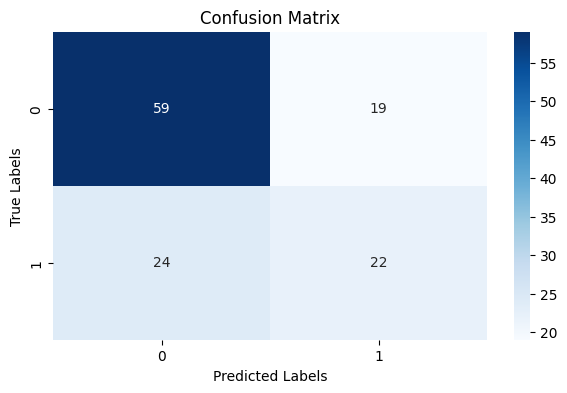

Epoch [17/50], Train Loss: 0.1170, Validation Loss: 0.6542, Accuracy: 65.32%


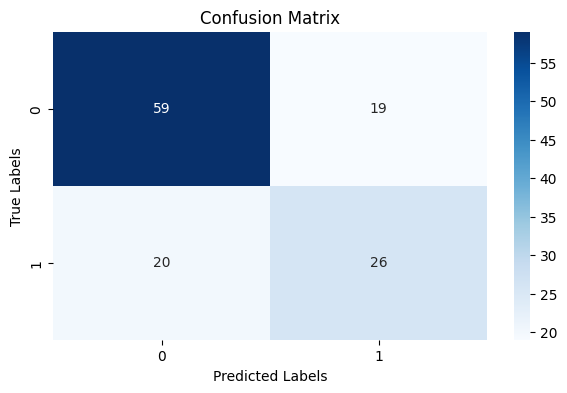

Epoch [18/50], Train Loss: 0.1078, Validation Loss: 0.6376, Accuracy: 68.55%


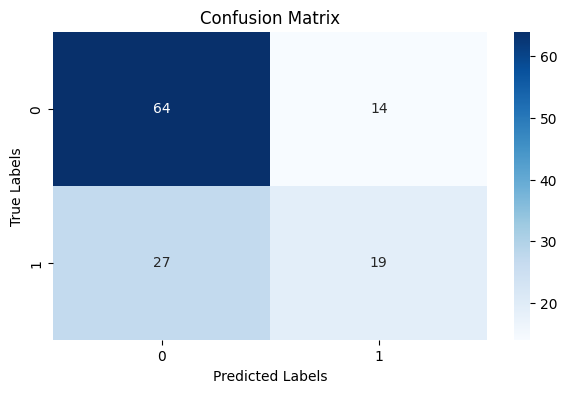

Epoch [19/50], Train Loss: 0.0873, Validation Loss: 0.7236, Accuracy: 66.94%


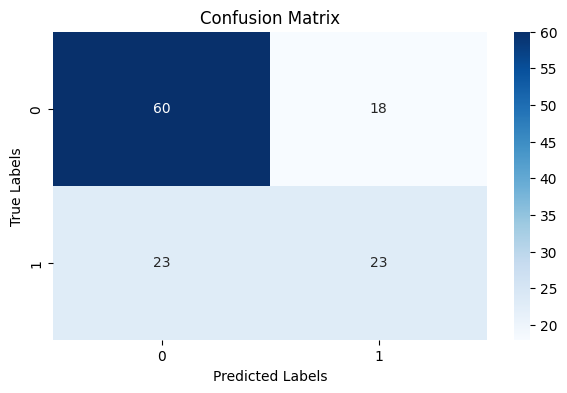

Epoch [20/50], Train Loss: 0.0733, Validation Loss: 0.7079, Accuracy: 66.94%


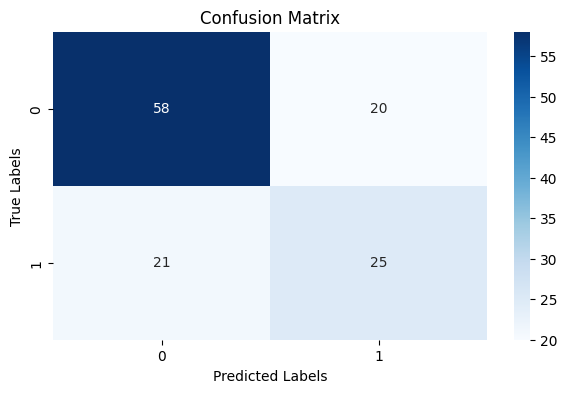

Epoch [21/50], Train Loss: 0.0646, Validation Loss: 0.6918, Accuracy: 66.94%


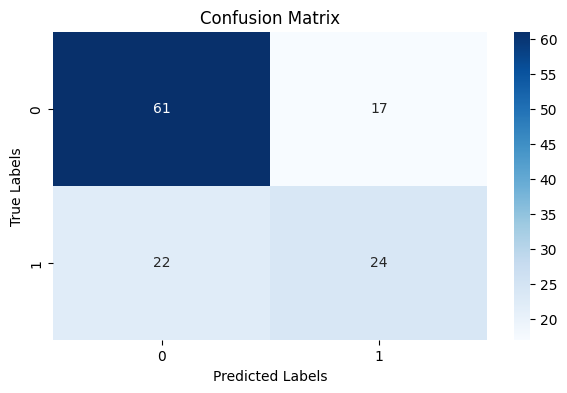

Epoch [22/50], Train Loss: 0.0614, Validation Loss: 0.7077, Accuracy: 68.55%


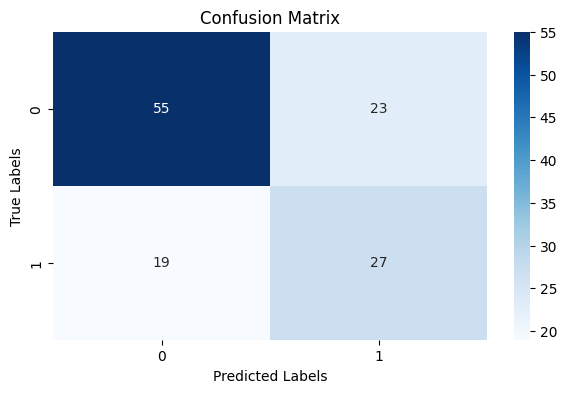

Epoch [23/50], Train Loss: 0.0497, Validation Loss: 0.7241, Accuracy: 66.13%


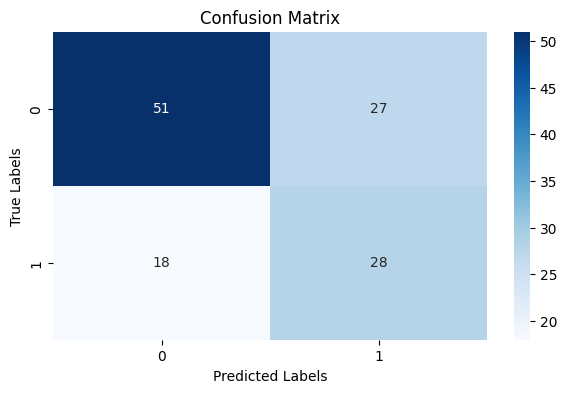

Epoch [24/50], Train Loss: 0.0486, Validation Loss: 0.7528, Accuracy: 63.71%


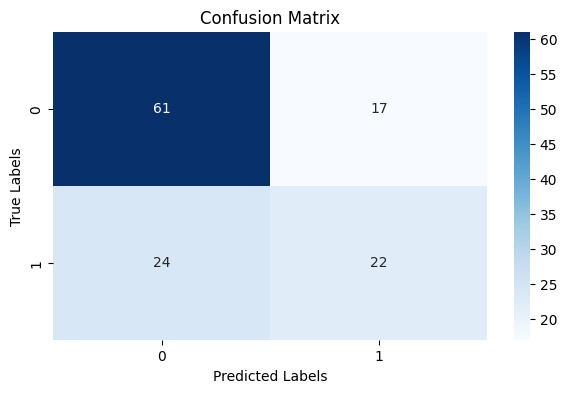

Epoch [25/50], Train Loss: 0.0488, Validation Loss: 0.8005, Accuracy: 66.94%


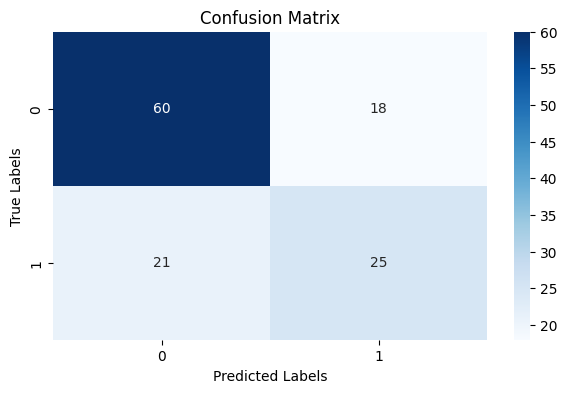

Epoch [26/50], Train Loss: 0.0336, Validation Loss: 0.8056, Accuracy: 68.55%


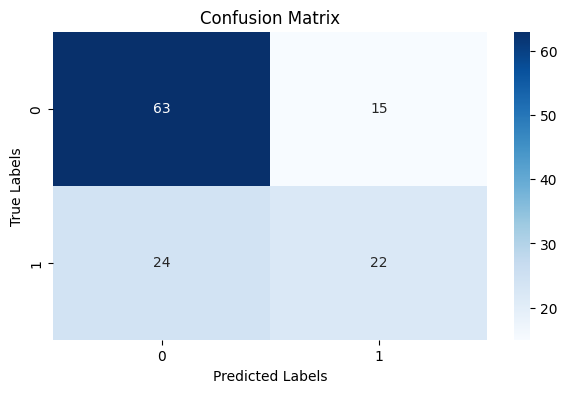

Epoch [27/50], Train Loss: 0.0456, Validation Loss: 0.8626, Accuracy: 68.55%


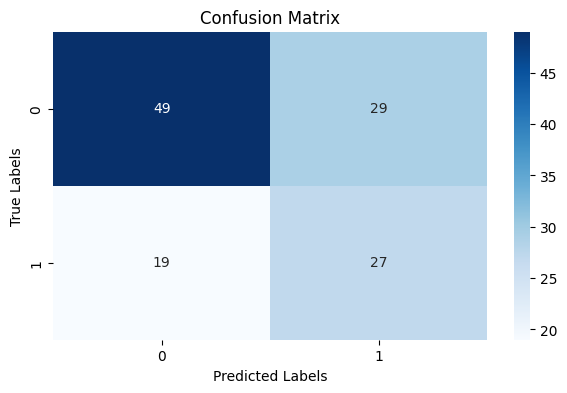

Epoch [28/50], Train Loss: 0.0511, Validation Loss: 0.9103, Accuracy: 61.29%


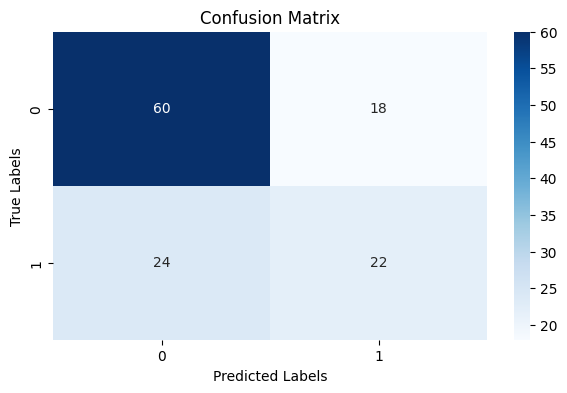

Epoch [29/50], Train Loss: 0.0476, Validation Loss: 0.9385, Accuracy: 66.13%


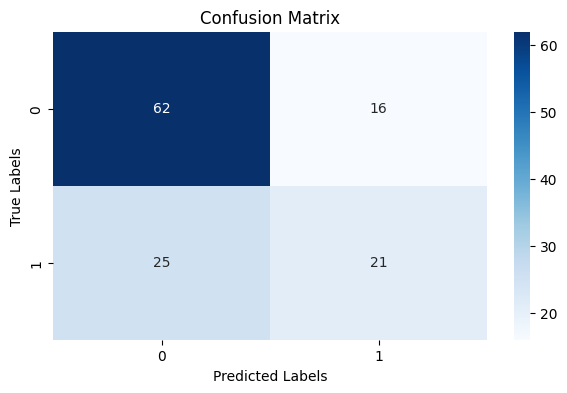

Epoch [30/50], Train Loss: 0.0383, Validation Loss: 0.9155, Accuracy: 66.94%


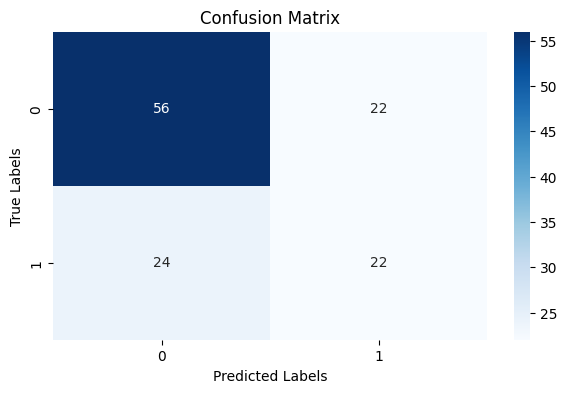

Epoch [31/50], Train Loss: 0.0376, Validation Loss: 0.9477, Accuracy: 62.90%


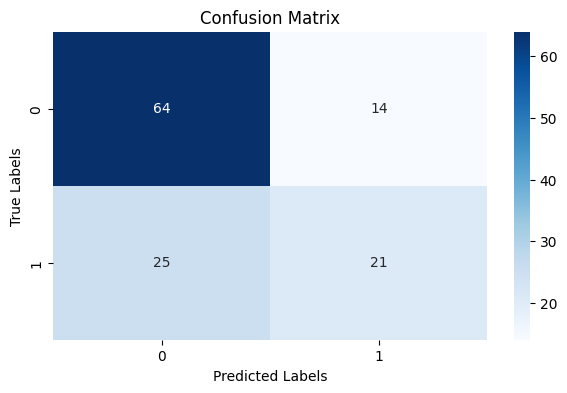

Epoch [32/50], Train Loss: 0.0310, Validation Loss: 0.9093, Accuracy: 68.55%


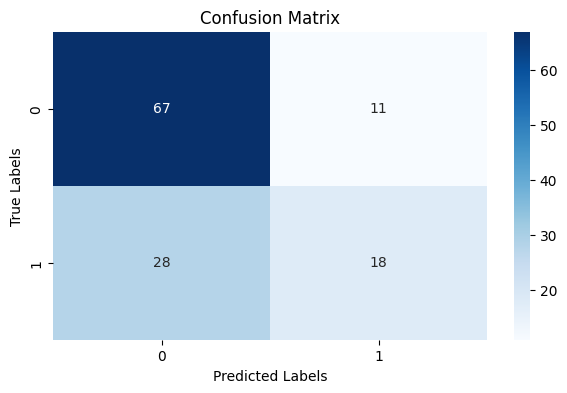

Epoch [33/50], Train Loss: 0.0366, Validation Loss: 1.0112, Accuracy: 68.55%


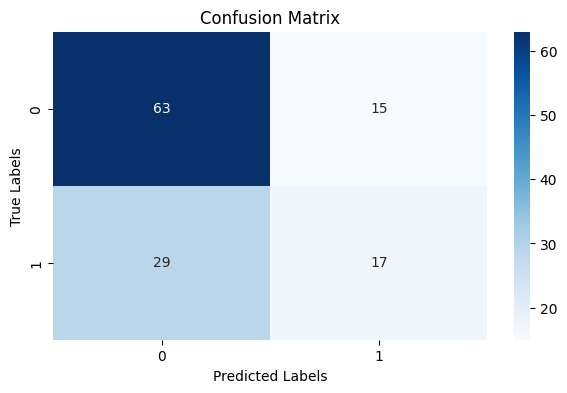

Epoch [34/50], Train Loss: 0.0265, Validation Loss: 1.0377, Accuracy: 64.52%


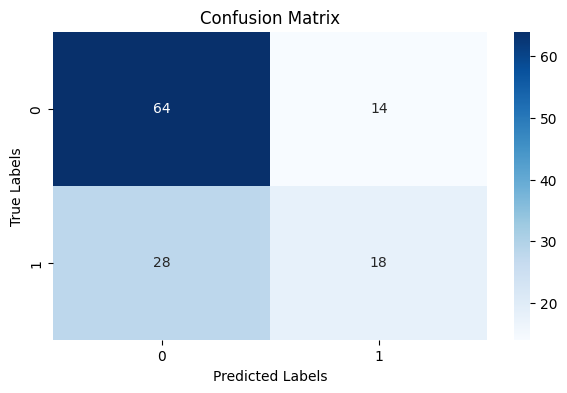

Epoch [35/50], Train Loss: 0.0243, Validation Loss: 1.0141, Accuracy: 66.13%


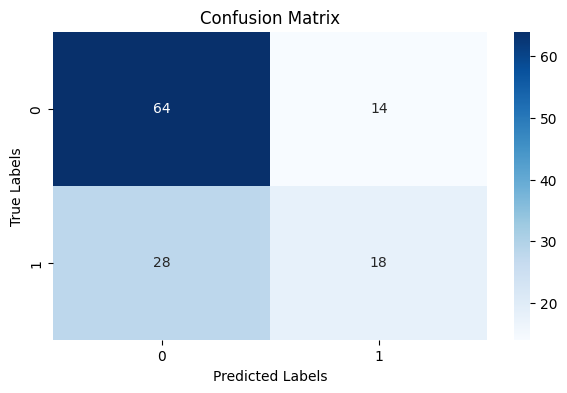

Epoch [36/50], Train Loss: 0.0192, Validation Loss: 1.0115, Accuracy: 66.13%


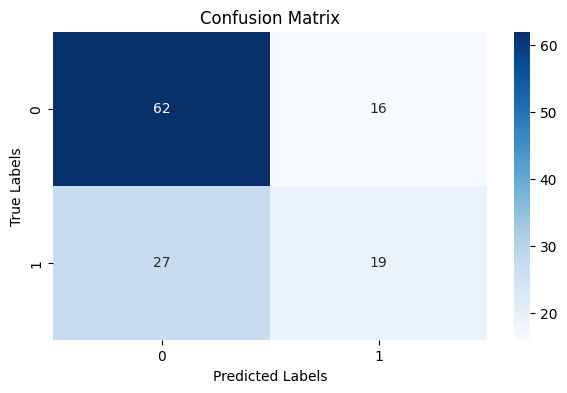

Epoch [37/50], Train Loss: 0.0206, Validation Loss: 1.0126, Accuracy: 65.32%


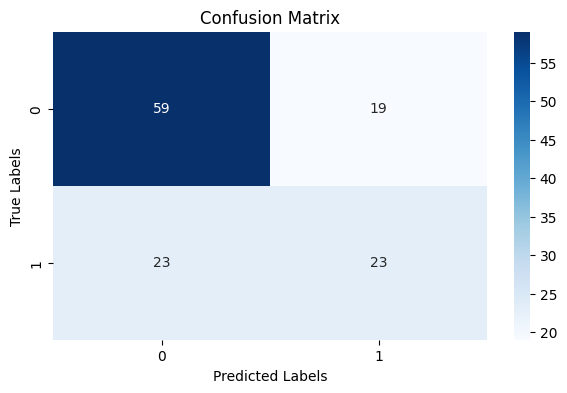

Epoch [38/50], Train Loss: 0.0155, Validation Loss: 0.9876, Accuracy: 66.13%


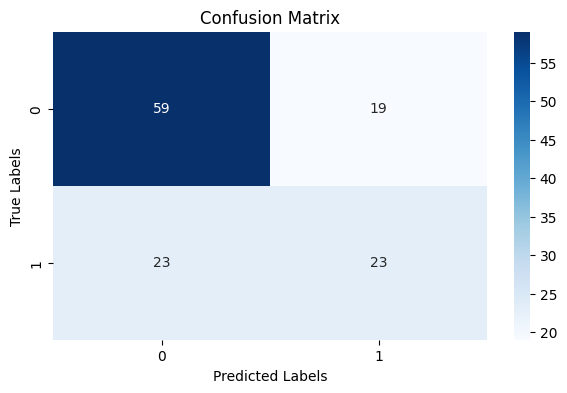

Epoch [39/50], Train Loss: 0.0148, Validation Loss: 0.9872, Accuracy: 66.13%


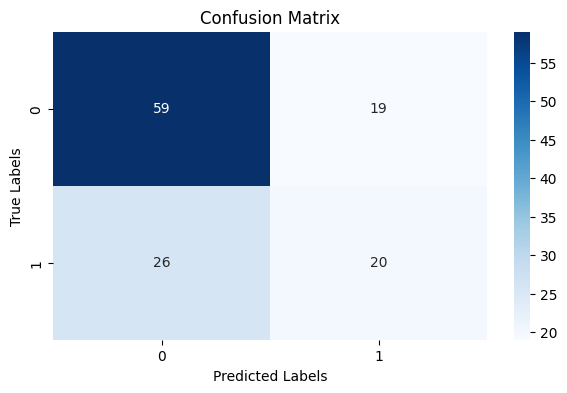

Epoch [40/50], Train Loss: 0.0188, Validation Loss: 0.9799, Accuracy: 63.71%


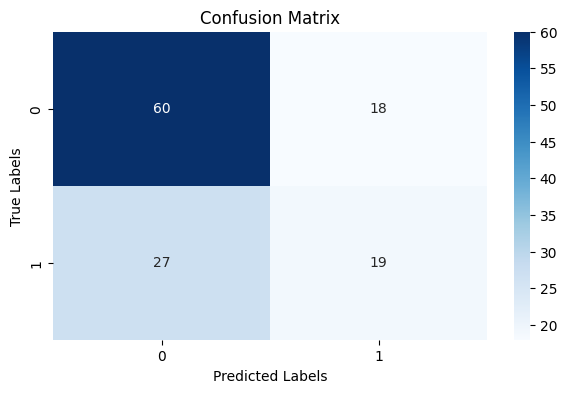

Epoch [41/50], Train Loss: 0.0172, Validation Loss: 1.0645, Accuracy: 63.71%


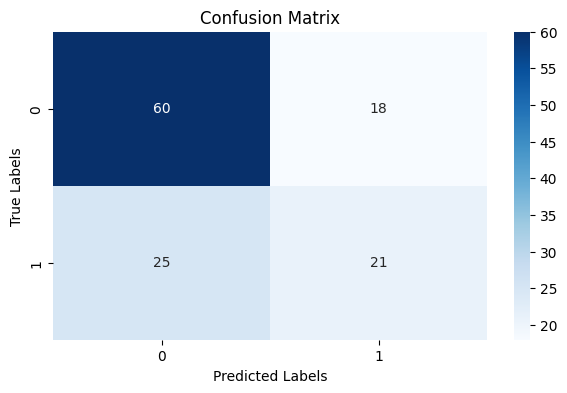

Epoch [42/50], Train Loss: 0.0149, Validation Loss: 1.1316, Accuracy: 65.32%


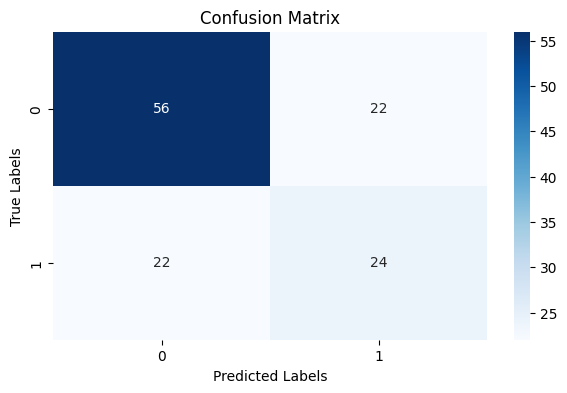

Epoch [43/50], Train Loss: 0.0165, Validation Loss: 1.0680, Accuracy: 64.52%


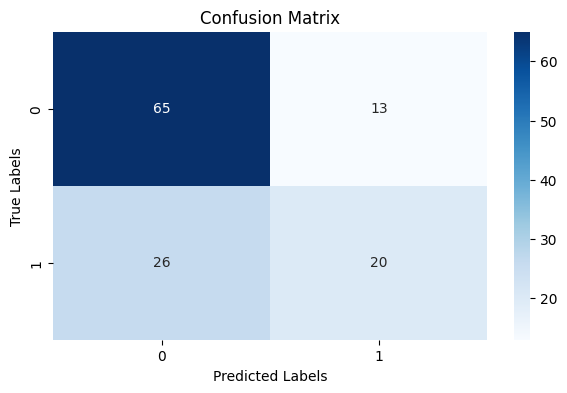

Epoch [44/50], Train Loss: 0.0140, Validation Loss: 1.1969, Accuracy: 68.55%


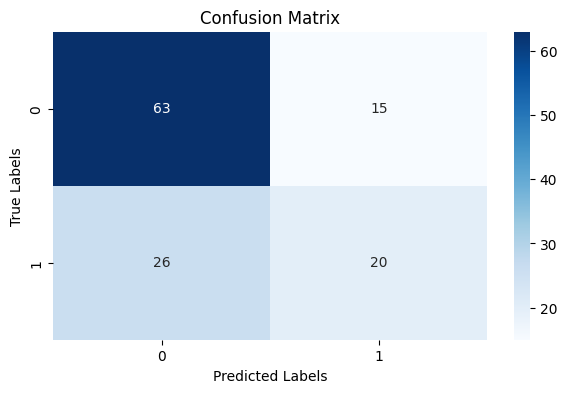

Epoch [45/50], Train Loss: 0.0210, Validation Loss: 1.1529, Accuracy: 66.94%


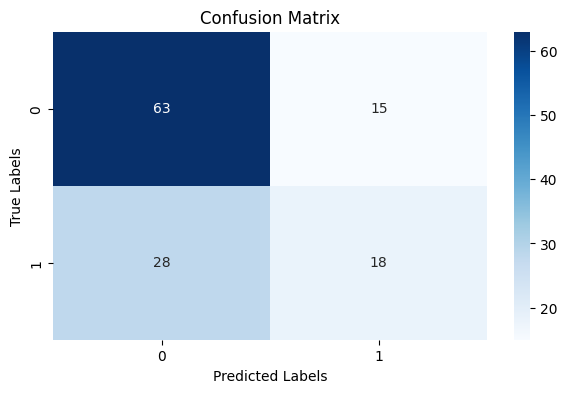

Epoch [46/50], Train Loss: 0.0199, Validation Loss: 1.3253, Accuracy: 65.32%


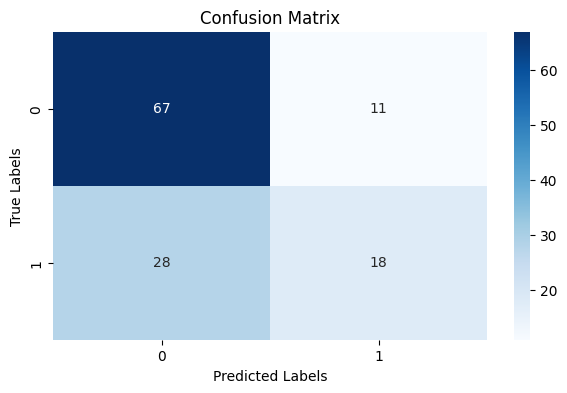

Epoch [47/50], Train Loss: 0.0245, Validation Loss: 1.2219, Accuracy: 68.55%


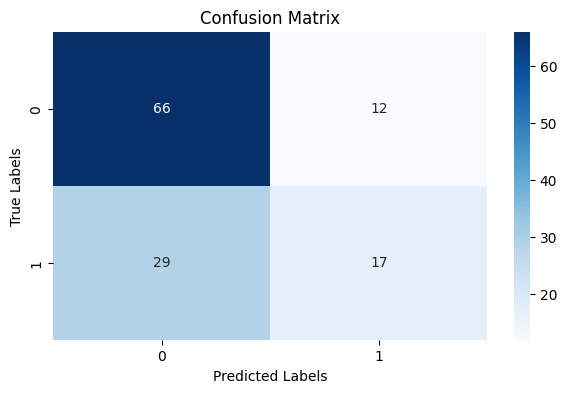

Epoch [48/50], Train Loss: 0.0132, Validation Loss: 1.3925, Accuracy: 66.94%


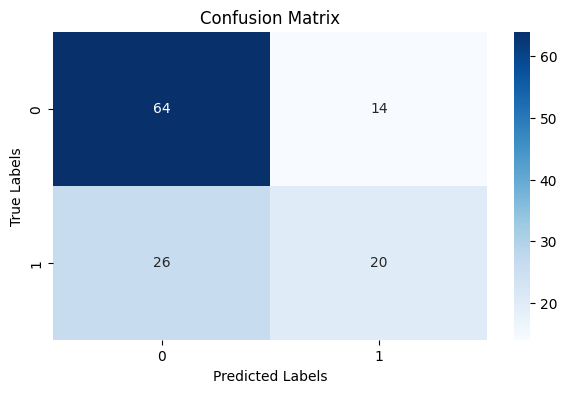

Epoch [49/50], Train Loss: 0.0316, Validation Loss: 1.1578, Accuracy: 67.74%


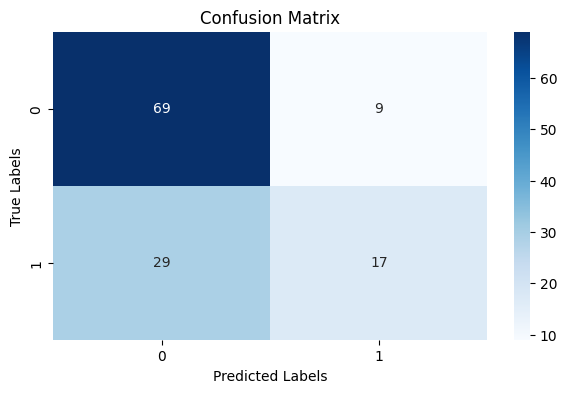

Epoch [50/50], Train Loss: 0.0236, Validation Loss: 1.3078, Accuracy: 69.35%


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.00003, weight_decay=1e-3)
num_epochs = 50
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    # Evaluación con el conjunto de validación/test
    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            predicted = torch.sigmoid(outputs).ge(0.5).float()  # ge es 'greater or equal'
            total += labels.size(0)
            correct += (predicted == labels).float().sum().item()  # Asegura que la suma se haga sobre floats
            all_predicted.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total

    all_predicted = np.concatenate(all_predicted)
    all_labels = np.concatenate(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [6]:
print((predicted == labels))

tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True]], device='cuda:0')
